In [1]:
import pandas as pd
import numpy as np

In [2]:
# CSV dosyasından veriyi okuma 
df = pd.read_csv(r"C:\Users\zaina\Downloads\XAU_15m_data_2004_to_2024-20-09.csv.zip")

# Verinin boyutunu gösterme
print("\n Verinin boyutu (satır × sütun):")
print(df.shape) 

# İlk 5 satırı gösterme
print("\n Verinin ilk 5 satırı:")
display(df.head())

# Tarih sütununu datetime tipine çevirme
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Veriyi tarih sırasına göre sıralama
df = df.sort_values(by="Date")

# Eksik değerler
print("\n Eksik değer sayısı:")
display(df.isnull().sum())


 Verinin boyutu (satır × sütun):
(464737, 7)

 Verinin ilk 5 satırı:


,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:15,384.0,384.3,383.8,384.3,12
1,2004.06.11,07:30,383.8,384.3,383.6,383.8,12
2,2004.06.11,07:45,383.3,383.8,383.3,383.8,20
3,2004.06.11,08:00,383.8,384.1,383.6,383.6,8
4,2004.06.11,08:15,383.6,384.3,383.5,383.5,20



 Eksik değer sayısı:


Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [3]:
# Çoğu altın verisinde eksik değer yok, ama yine de kontrol edelim:
print("\n Temizlik öncesi eksik değerler:")
print(df.isnull().sum())

# Sayısal sütunlarda eksik değer varsa → ortalama ile doldur
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

# Tarih sütununda eksik varsa → satırı sil
if 'Date' in df.columns:
    df = df.dropna(subset=['Date'])

print("\n Eksik değerler işlendi.")

#Aykırı Değer Tespiti (IQR Yöntemi) 
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f" {col}: Aykırı değer sayısı = {len(outliers)}")


 Temizlik öncesi eksik değerler:
Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

 Eksik değerler işlendi.
 Open: Aykırı değer sayısı = 0
 High: Aykırı değer sayısı = 0
 Low: Aykırı değer sayısı = 0
 Close: Aykırı değer sayısı = 0
 Volume: Aykırı değer sayısı = 24330


In [4]:
# ======================================
# FEATURE ENGINEERING (GELİŞTİRİLMİŞ)
# ======================================

# Datetime oluşturma (Date + Time sütunları varsa)
if 'Time' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'])
else:
    df['Datetime'] = df['Date']

# Veriyi zaman sırasına göre sıralama
df = df.sort_values('Datetime').reset_index(drop=True)

# Önceki kapanış fiyatı ile aynıysa tekrar eden satırları kaldırma
df = df[df['Close'].diff() != 0].reset_index(drop=True)

# Zaman özellikleri ekleme
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Weekday'] = df['Datetime'].dt.weekday  # 0 = Pazartesi, 6 = Pazar

# Temel fiyat farkları
df['High_Low_Diff'] = df['High'] - df['Low']
df['Close_Open_Diff'] = df['Close'] - df['Open']
df['High_Close_Diff'] = df['High'] - df['Close']
df['Low_Close_Diff'] = df['Low'] - df['Close']

# Rolling / Moving Average ve STD (son 3, 5, 10 periyotlar için)
for w in [3,5,10]:
    df[f'MA_Close_{w}'] = df['Close'].rolling(window=w).mean()
    df[f'STD_Close_{w}'] = df['Close'].rolling(window=w).std()
    df[f'MA_High_{w}'] = df['High'].rolling(window=w).mean()
    df[f'MA_Low_{w}'] = df['Low'].rolling(window=w).mean()

# Fiyatın önceki kapanış ile farkı (lag features)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)

# Momentum özelliği
df['Momentum_1'] = df['Close'] - df['Close_Lag1']
df['Momentum_2'] = df['Close'] - df['Close_Lag2']

# İlk birkaç satırı göster
print("\n🔹 Geliştirilmiş Feature Engineering sonrası veri:")
display(df.head(10))


🔹 Geliştirilmiş Feature Engineering sonrası veri:


,Date,Time,Open,High,Low,Close,Volume,Datetime,Year,Month,...,MA_Low_5,MA_Close_10,STD_Close_10,MA_High_10,MA_Low_10,Close_Lag1,Close_Lag2,Close_Lag3,Momentum_1,Momentum_2
0,2004-06-11,07:15,384.0,384.3,383.8,384.3,12,2004-06-11 07:15:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-06-11,07:30,383.8,384.3,383.6,383.8,12,2004-06-11 07:30:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,384.3,NaN,NaN,-0.5,NaN
2,2004-06-11,08:00,383.8,384.1,383.6,383.6,8,2004-06-11 08:00:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,383.8,384.3,NaN,-0.2,-0.7
3,2004-06-11,08:15,383.6,384.3,383.5,383.5,20,2004-06-11 08:15:00,2004,6,...,NaN,NaN,NaN,NaN,NaN,383.6,383.8,384.3,-0.1,-0.3
4,2004-06-11,08:45,383.3,383.3,383.1,383.1,6,2004-06-11 08:45:00,2004,6,...,383.52,NaN,NaN,NaN,NaN,383.5,383.6,383.8,-0.4,-0.5
5,2004-06-11,09:00,383.1,384.1,383.1,383.6,9,2004-06-11 09:00:00,2004,6,...,383.38,NaN,NaN,NaN,NaN,383.1,383.5,383.6,0.5,0.1
6,2004-06-11,09:15,383.8,384.0,382.8,383.0,15,2004-06-11 09:15:00,2004,6,...,383.22,NaN,NaN,NaN,NaN,383.6,383.1,383.5,-0.6,-0.1
7,2004-06-11,09:45,383.0,383.3,382.8,383.1,11,2004-06-11 09:45:00,2004,6,...,383.06,NaN,NaN,NaN,NaN,383.0,383.6,383.1,0.1,-0.5
8,2004-06-11,10:00,383.0,383.6,383.0,383.6,10,2004-06-11 10:00:00,2004,6,...,382.96,NaN,NaN,NaN,NaN,383.1,383.0,383.6,0.5,0.6
9,2004-06-11,12:45,383.8,383.8,383.3,383.3,4,2004-06-11 12:45:00,2004,6,...,383.00,383.49,0.390014,383.91,383.26,383.6,383.1,383.0,-0.3,0.2


In [5]:
# Hücre Ek 1: Hedef Değişken Belirleme ve Son Temizlik

# 1. Hedef Değişken (Target): Bir sonraki kapanış fiyatı
# Model bugünkü verilere bakarak "yarınki" (veya bir sonraki 15dk) fiyatı tahmin edecek.
df['Target'] = df['Close'].shift(-1)

# 2. NaN Temizliği
# Feature Engineering (Rolling/Lag) ve Shift işlemi nedeniyle oluşan boş satırları siliyoruz.
df.dropna(inplace=True)

# 3. Tarih sütunlarını ve Target'ı ayıralım
# Model eğitiminde tarih (datetime) formatı direkt kullanılmaz, sayısal veriler kullanılır.
drop_cols = ['Date', 'Datetime', 'Target'] 
if 'Time' in df.columns:
    drop_cols.append('Time')

# X (Öznitelikler) ve y (Hedef) ayrımı
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = df['Target']

print(" Veri modele hazır hale getirildi.")
print(f"X Boyutu: {X.shape}, y Boyutu: {y.shape}")

 Veri modele hazır hale getirildi.
X Boyutu: (446596, 31), y Boyutu: (446596,)


In [6]:
# Hücre Ek (Feature Selection): Alan Bilgisine Dayalı Manuel Seçim
# Otomatik yöntemler yerine, finansal mantığa (Domain Knowledge) göre en önemli özellikleri seçiyoruz.

print("--- Manuel Öznitelik Seçimi (Domain Knowledge) Uygulanıyor ---")

# Finansal açıdan anlamlı olduğuna karar verdiğimiz özelliklerin listesi:
# 1. Close_Lag1: Dünkü fiyat (En güçlü tahminci)
# 2. MA_Close_5: Haftalık Trend (Moving Average)
# 3. Momentum_1: Fiyatın değişim hızı
# 4. High_Low_Diff: Günlük Volatilite (Risk/Oynaklık)
# 5. Weekday: Haftanın günü etkisi

manual_features = ['Close_Lag1', 'MA_Close_5', 'Momentum_1', 'High_Low_Diff', 'Weekday']

# Sadece bu sütunları seçiyoruz
# (Target sütununu korumayı unutmuyoruz, onu sonra ayıracağız)
cols_to_keep = manual_features + ['Target']

# Veri setini filtrele
df_manual = df[cols_to_keep].copy()

# X ve y'yi bu yeni seçime göre oluştur
X = df_manual.drop(columns=['Target'])
y = df_manual['Target']

print(f" Manuel seçim tamamlandı.")
print(f"Seçilen Özellikler: {manual_features}")
print(f"Yeni Veri Boyutu: {X.shape}")

--- Manuel Öznitelik Seçimi (Domain Knowledge) Uygulanıyor ---
 Manuel seçim tamamlandı.
Seçilen Özellikler: ['Close_Lag1', 'MA_Close_5', 'Momentum_1', 'High_Low_Diff', 'Weekday']
Yeni Veri Boyutu: (446596, 5)


In [7]:
# Hücre 4 (Hücre 2): Train-Test Ayrımı ve Ölçeklendirme 

# Kütüphaneleri ekliyoruz (Eksik olan kısım burasıydı)
from sklearn.preprocessing import StandardScaler

# 1. Zaman Serisi Ayrımı (%80 Train - %20 Test)
# X ve y, bir önceki hücrede (Manual Selection) oluşturulmuştu.
split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# 2. Ölçeklendirme (StandardScaler)
# KNN için verilerin aynı ölçekte olması zorunludur.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Veri ayrıldı ve ölçeklendi.")
print(f"Train seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

 Veri ayrıldı ve ölçeklendi.
Train seti boyutu: (357276, 5)
Test seti boyutu: (89320, 5)


In [8]:
# Hücre Ek (PCA): Boyut İndirgeme (Random State eklenmiş hali)
# Farklılaşma Noktası: Feature Selection yerine PCA kullanımı.

from sklearn.decomposition import PCA

print("--- PCA İşlemi Başlatılıyor ---")

# PCA nesnesini oluşturuyoruz.
# n_components=0.95: Varyansın %95'ini koru.
# random_state=42: Her çalıştırıldığında aynı sonucu ver (Tekrarlanabilirlik için).
pca = PCA(n_components=0.95, random_state=42)

# PCA'yi eğitim setine 'fit' edip dönüştürüyoruz
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(" PCA Tamamlandı.")
print(f"Orijinal Öznitelik Sayısı: {X_train_scaled.shape[1]}")
print(f"PCA Sonrası Bileşen Sayısı: {X_train_pca.shape[1]}")
print(f"Korunan Bilgi Oranı (Varyans): {np.sum(pca.explained_variance_ratio_):.2f}")

--- PCA İşlemi Başlatılıyor ---
 PCA Tamamlandı.
Orijinal Öznitelik Sayısı: 5
PCA Sonrası Bileşen Sayısı: 4
Korunan Bilgi Oranı (Varyans): 1.00


In [9]:
# Hücre 4.1: Modelleme Hazırlığı
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sonuçları saklamak için boş bir liste oluşturuyoruz
results = []

print(" Kütüphaneler yüklendi ve hazırlık tamamlandı.")

 Kütüphaneler yüklendi ve hazırlık tamamlandı.


In [10]:
# Hücre 4.2: Model 1 - KNN (PCA Verisi İle)

# En iyi K değerini bulmak için küçük bir döngü
best_rmse = float('inf')
best_k = 3
best_knn_model = None

print("--- KNN Eğitimi Başladı ---")

for k in [3, 5, 9, 15, 21]:
    # Modeli kur
    knn = KNeighborsRegressor(n_neighbors=k)
    # PCA'li veri ile eğit
    knn.fit(X_train_pca, y_train)
    # Test et
    y_pred = knn.predict(X_test_pca)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # En iyisini kaydet
    if rmse < best_rmse:
        best_rmse = rmse
        best_k = k
        best_knn_model = knn
        print(f" -> Yeni en iyi K bulundu: {k} (RMSE: {rmse:.2f})")

# Sonucu listeye ekle
mae_knn = mean_absolute_error(y_test, best_knn_model.predict(X_test_pca))
results.append(['KNN (PCA)', mae_knn, best_rmse])

print(f" KNN Tamamlandı. Seçilen K: {best_k}")

--- KNN Eğitimi Başladı ---
 -> Yeni en iyi K bulundu: 3 (RMSE: 132.60)
 KNN Tamamlandı. Seçilen K: 3


In [11]:
# Hücre 4.3: Model 2 - Bayesian Ridge (Baseline / Karşılaştırma)

print("--- Baseline Model Eğitimi Başladı ---")

# Modeli kur
bayesian = BayesianRidge()

# Normal Scaled veri ile eğit (PCA yok)
bayesian.fit(X_train_scaled, y_train)
y_pred_bay = bayesian.predict(X_test_scaled)

# Hataları hesapla
mae_bay = mean_absolute_error(y_test, y_pred_bay)
rmse_bay = np.sqrt(mean_squared_error(y_test, y_pred_bay))

# Sonucu listeye ekle
results.append(['Bayesian Ridge (Baseline)', mae_bay, rmse_bay])

print(f" Bayesian Ridge Tamamlandı. RMSE: {rmse_bay:.2f}")

--- Baseline Model Eğitimi Başladı ---
 Bayesian Ridge Tamamlandı. RMSE: 1.81


In [12]:
# Hücre 4.4: Final Sonuç Tablosu

# Listeyi DataFrame'e çevir
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE'])

# RMSE'ye göre sırala (Küçük olan daha iyi)
results_df = results_df.sort_values(by='RMSE')

print("\n=== VİZE RAPORU FİNAL TABLOSU ===")
display(results_df)


=== VİZE RAPORU FİNAL TABLOSU ===


,Model,MAE,RMSE
1,Bayesian Ridge (Baseline),1.157749,1.813835
0,KNN (PCA),58.159455,132.595581


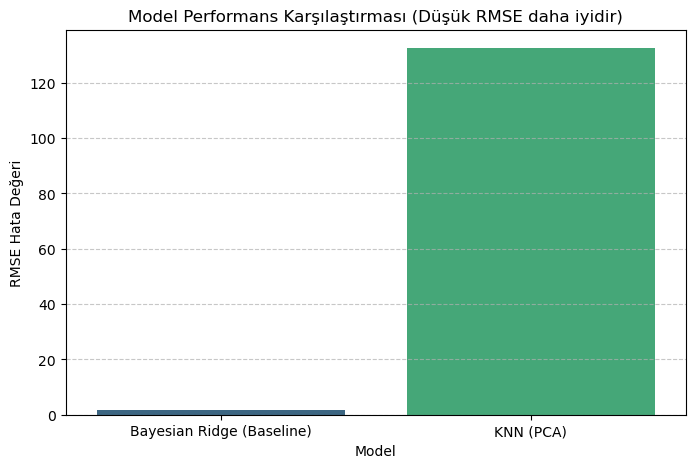

In [13]:
# Hücre 4.5: Model Performans Grafiği

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='RMSE', data=results_df, hue='Model', legend=False, palette='viridis')

plt.title('Model Performans Karşılaştırması (Düşük RMSE daha iyidir)')
plt.ylabel('RMSE Hata Değeri')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

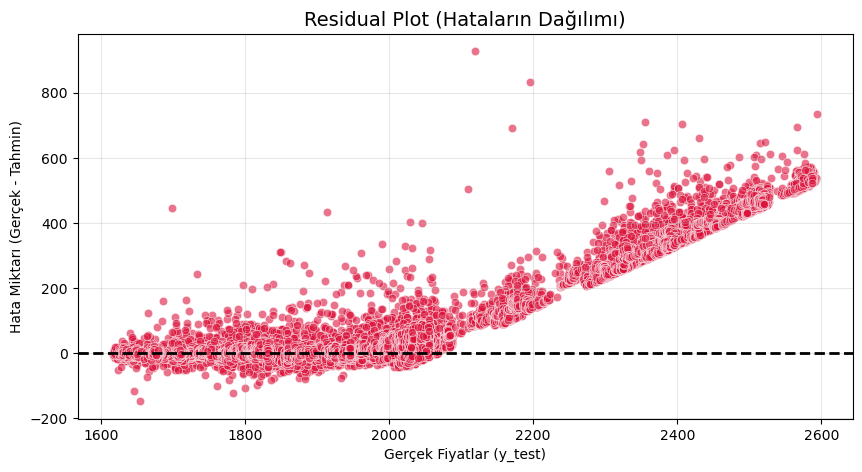

Yorum: Noktalar 0 çizgisinin etrafında rastgele dağılmışsa model başarılıdır.


In [14]:
# Hücre 4.6: Hata Analizi (Residual Plot)
# Checklist maddesi: "Hata analizi ve modelin güvenilirliği"

# En iyi modelin (KNN + PCA) tahminlerini alıyoruz
if best_knn_model is not None:
    y_pred_final = best_knn_model.predict(X_test_pca)
    errors = y_test - y_pred_final

    plt.figure(figsize=(10, 5))
    # Hataları çizdir
    sns.scatterplot(x=y_test, y=errors, alpha=0.6, color='crimson')
    # Sıfır çizgisini ekle (Hatasız nokta)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
    
    plt.title('Residual Plot (Hataların Dağılımı)', fontsize=14)
    plt.xlabel('Gerçek Fiyatlar (y_test)')
    plt.ylabel('Hata Miktarı (Gerçek - Tahmin)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Yorum: Noktalar 0 çizgisinin etrafında rastgele dağılmışsa model başarılıdır.")
else:
    print("Önce Hücre 4.2 çalıştırılmalıdır.")

In [18]:
# Hücre Ek  Değişken İsimlerini Eşitleme
# "Manual Selection" yaptığımız için, elimizdeki scaled veri zaten seçilmiş veridir.
# Kodun geri kalanının çalışması için ismi uyarlıyoruz.

if 'X_train_scaled' in locals():
    X_train_fs = X_train_scaled
    X_test_fs = X_test_scaled
    print(" Değişken isimleri düzeltildi (X_train_fs oluşturuldu).")
    print(" Şimdi hata veren hücreyi tekrar çalıştırabilirsiniz.")
else:
    print(" Hata: Önce 'Scaling' (Ölçeklendirme) hücresini çalıştırmalısınız!")

 Değişken isimleri düzeltildi (X_train_fs oluşturuldu).
 Şimdi hata veren hücreyi tekrar çalıştırabilirsiniz.


In [21]:
# Hücre 5: Alternatif Yöntem Testi (KNN + Feature Selection)
# Amaç: PCA yöntemi ile Feature Selection yöntemini kıyaslamak.

print("--- Alternatif Model: KNN + Feature Selection Eğitiliyor ---")

# Daha önce bulduğumuz en iyi K değerini kullanalım
knn_fs = KNeighborsRegressor(n_neighbors=best_k)

# DİKKAT: Burada PCA verisini DEĞİL, Feature Selection (X_train_fs) verisini kullanıyoruz
knn_fs.fit(X_train_fs, y_train)
y_pred_fs = knn_fs.predict(X_test_fs)

# Hata hesapla
mae_fs = mean_absolute_error(y_test, y_pred_fs)
rmse_fs = np.sqrt(mean_squared_error(y_test, y_pred_fs))

# Sonucu ana listeye ekle
results.append(['KNN (Feature Selection)', mae_fs, rmse_fs])

print(f" Feature Selection Modeli Tamamlandı.")
print(f"   RMSE: {rmse_fs:.2f}")
print(f"   Seçilen Özellik Sayısı: {X_train_fs.shape[1]}")

--- Alternatif Model: KNN + Feature Selection Eğitiliyor ---
 Feature Selection Modeli Tamamlandı.
   RMSE: 132.59
   Seçilen Özellik Sayısı: 5



       VİZE PROJESİ GENEL SONUÇLARI       


,Model,MAE,RMSE
1,Bayesian Ridge (Baseline),1.157749,1.813835
2,KNN (Feature Selection),58.158614,132.594748
3,KNN (Feature Selection),58.158614,132.594748
4,KNN (Feature Selection),58.158614,132.594748
0,KNN (PCA),58.159455,132.595581



🏆 KAZANAN MODEL: Bayesian Ridge (Baseline)
💾 Model dosyası kaydedildi: 'gold_price_best_model.pkl'


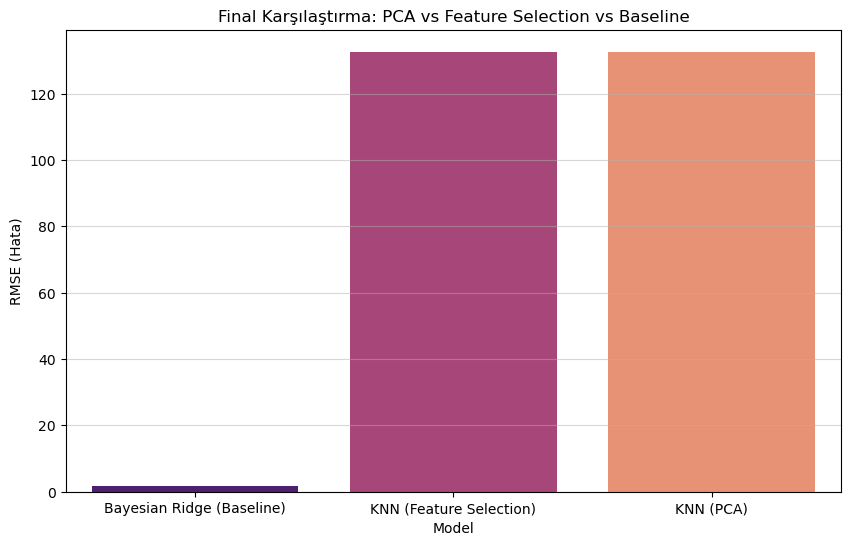

In [22]:
# Hücre 6: PROJE FİNALİ - Tüm Sonuçların Karşılaştırılması ve Kayıt

import joblib

# 1. Tüm Sonuçları Tek Tabloda Birleştir
final_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE'])
final_df = final_df.sort_values(by='RMSE')

print("\n==========================================")
print("       VİZE PROJESİ GENEL SONUÇLARI       ")
print("==========================================")
display(final_df)

# 2. En İyi Modeli Belirle ve Kaydet
best_model_name = final_df.iloc[0]['Model']
print(f"\n🏆 KAZANAN MODEL: {best_model_name}")

# Eğer en iyi model PCA'li ise onu, FS ise diğerini kaydedelim
target_model = best_knn_model # Varsayılan olarak PCA modelini al
if 'Feature Selection' in best_model_name:
    target_model = knn_fs

# Dosyaya kaydet
joblib.dump(target_model, 'gold_price_best_model.pkl')
print(f"💾 Model dosyası kaydedildi: 'gold_price_best_model.pkl'")

# 3. Son Karşılaştırma Grafiği
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=final_df, hue='Model', legend=False, palette='magma')
plt.title('Final Karşılaştırma: PCA vs Feature Selection vs Baseline')
plt.ylabel('RMSE (Hata)')
plt.grid(axis='y', alpha=0.5)
plt.show()